In [1]:
import sqlite3
import pandas as pd


conn = sqlite3.connect("database.sqlite")


tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';",conn)
print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [2]:
Players_df = pd.read_sql("SELECT * FROM Player",conn)
matches_df = pd.read_sql("SELECT * FROM Match",conn)
leagues_df = pd.read_sql("SELECT * FROM League",conn)
teams_df = pd.read_sql("SELECT * FROM Team",conn)

In [4]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('database.sqlite')  # <-- update path if needed

# Check all available tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)

Tables in the database:
                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [5]:
# Load the Match table
matches_df = pd.read_sql("SELECT season, home_team_goal, away_team_goal FROM Match", conn)
matches_df.head()

,season,home_team_goal,away_team_goal
0,2008/2009,1,1
1,2008/2009,0,0
2,2008/2009,0,3
3,2008/2009,5,0
4,2008/2009,1,3


In [6]:
# Add total goals per match
matches_df['total_goals'] = matches_df['home_team_goal'] + matches_df['away_team_goal']

# Group by season and calculate average goals per match
avg_goals_per_season = matches_df.groupby('season')['total_goals'].mean().reset_index()
avg_goals_per_season.columns = ['Season', 'Average Goals per Match']

avg_goals_per_season

,Season,Average Goals per Match
0,2008/2009,2.607336
1,2009/2010,2.672446
2,2010/2011,2.683742
3,2011/2012,2.716460
4,2012/2013,2.772699
5,2013/2014,2.766821
6,2014/2015,2.675789
7,2015/2016,2.754660


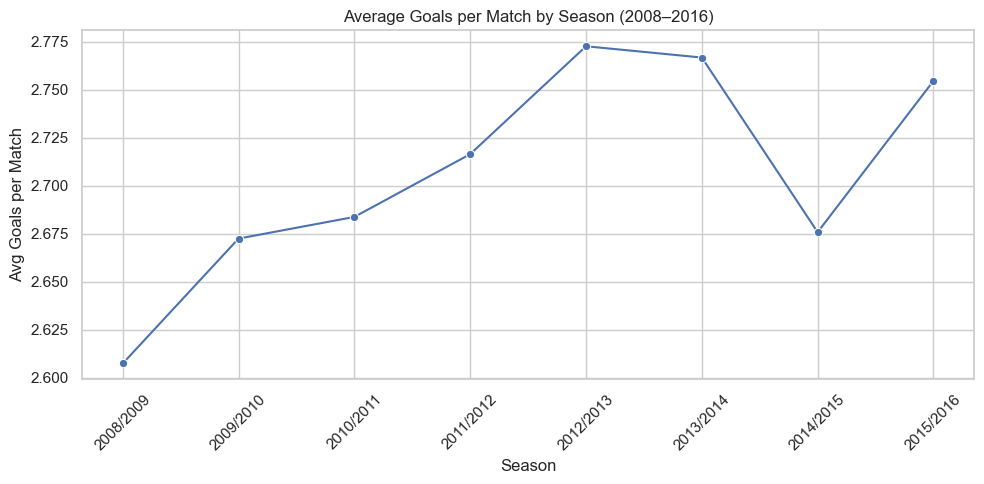

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")

# Plot the trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_goals_per_season, x='Season', y='Average Goals per Match', marker='o')

plt.title('Average Goals per Match by Season (2008–2016)')
plt.xlabel('Season')
plt.ylabel('Avg Goals per Match')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Load the Team table
teams_df = pd.read_sql("SELECT team_api_id, team_long_name FROM Team", conn)
teams_df.head()

,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge


In [9]:
# Load relevant columns from Match table
matches = pd.read_sql("""
    SELECT season, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
    FROM Match
""", conn)

# Create home goals DataFrame
home_goals = matches[['season', 'home_team_api_id', 'home_team_goal']].copy()
home_goals.columns = ['season', 'team_api_id', 'goals']

# Create away goals DataFrame
away_goals = matches[['season', 'away_team_api_id', 'away_team_goal']].copy()
away_goals.columns = ['season', 'team_api_id', 'goals']

# Combine home and away
all_goals = pd.concat([home_goals, away_goals], axis=0)

# Total goals by team and season
team_goals = all_goals.groupby(['season', 'team_api_id'])['goals'].sum().reset_index()

In [10]:
# Merge with team names
team_goals_named = team_goals.merge(teams_df, on='team_api_id')
team_goals_named = team_goals_named[['season', 'team_long_name', 'goals']]
team_goals_named.columns = ['Season', 'Team', 'Total Goals']
team_goals_named.head()

,Season,Team,Total Goals
0,2008/2009,Ruch Chorzów,22
1,2008/2009,Jagiellonia Białystok,28
2,2008/2009,Lech Poznań,51
3,2008/2009,P. Warszawa,40
4,2008/2009,Cracovia,24


In [11]:
# Get top 5 teams per season
top5_per_season = team_goals_named.sort_values(['Season', 'Total Goals'], ascending=[True, False])
top5_per_season = top5_per_season.groupby('Season').head(5)

top5_per_season

,Season,Team,Total Goals
76,2008/2009,FC Barcelona,105
164,2008/2009,BSC Young Boys,85
75,2008/2009,Real Madrid CF,83
96,2008/2009,VfL Wolfsburg,80
139,2008/2009,Atlético Madrid,80
253,2009/2010,Ajax,106
224,2009/2010,Chelsea,103
260,2009/2010,Real Madrid CF,102
261,2009/2010,FC Barcelona,98
329,2009/2010,FC Basel,90


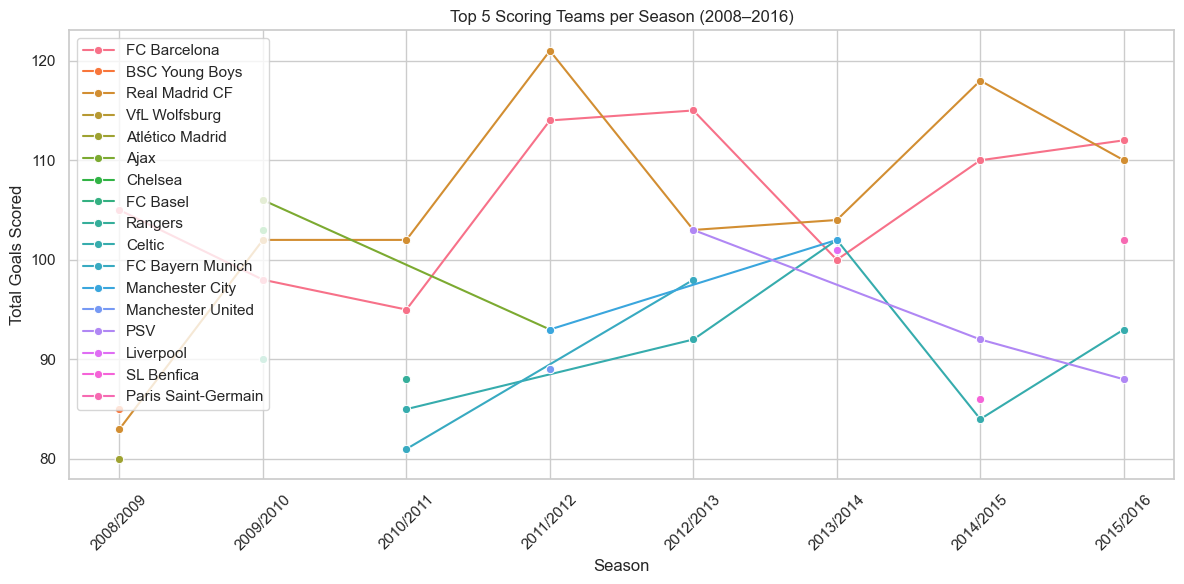

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=top5_per_season, x='Season', y='Total Goals', hue='Team', marker='o')

plt.title('Top 5 Scoring Teams per Season (2008–2016)')
plt.xlabel('Season')
plt.ylabel('Total Goals Scored')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()